In [14]:
%pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.


In [15]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

## Application state

##### The LangGraph state of our application controls what data is input to the application, transferred between steps, and output by the application

In [16]:
#keep track of the input question, generated query, query result, and generated answer
from typing_extensions import TypedDict


class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

## Convert question to SQL query

In [17]:
%pip install -qU "langchain[google-genai]"

Note: you may need to restart the kernel to use updated packages.


In [18]:
import getpass
import os

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

## Instructions for the model

In [19]:
from langchain_core.prompts import ChatPromptTemplate

system_message = """
Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}
"""

user_prompt = "Question: {input}"

query_prompt_template = ChatPromptTemplate(
    [("system", system_message), ("user", user_prompt)]
)

for message in query_prompt_template.messages:
    message.pretty_print()

================================ System Message ================================


Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}

================================ Human Message =================================

Question: {input}


### Populate requierd input values

In [20]:
from typing_extensions import  Annotated

# Defines a structured output format 
class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]

# Main function that creates SQL queries
def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }

    )

    # Configures the LLM to return structured output instead of free text
    structured_llm = llm.with_structured_output(QueryOutput)

    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

In [21]:
write_query({"question": "How many Employees are there?"})

{'query': 'SELECT COUNT(*) FROM Employee;'}

## Execute query


In [22]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool


def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

## Generate answer

In [24]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f"Question: {state['question']}\n"
        f"SQL Query: {state['query']}\n"
        f"SQL Result: {state['result']}"
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

## Orchestrating with LangGraph

In [28]:

from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

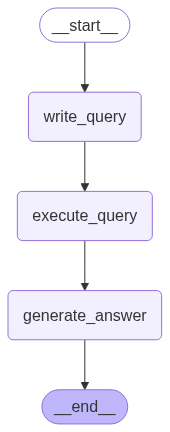

In [29]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [30]:
for step in graph.stream(
    {"question": "How many employees are there?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT COUNT(EmployeeId) FROM Employee;'}}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': 'There are 8 employees.'}}


## Human-in-the-loop

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory, interrupt_before=["execute_query"])


config = {"configurable": {"thread_id": "1"}}

In [36]:
for step in graph.stream(
    {"question": "How many employees are there?"},
    config,
    stream_mode="updates",
):
    print(step)

try:
    user_approval = input("Do you want to go to execute query? (yes/no): ")
except Exception:
    user_approval = "no"

if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    for step in graph.stream(None, config, stream_mode="updates"):
        print(step)
else:
    print("Operation cancelled by user.")

{'write_query': {'query': 'SELECT COUNT(*) FROM Employee'}}
{'__interrupt__': ()}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': 'There are 8 employees.'}}
